### Machine Learning for Systems & Control 5SC28 2023-2024

# Exercise set for Lecture 8:  Actor-Critic Methods


## Table of contents

1. <a href="#Exercise-0:-Installations">Exercise 0: Installations</a>
2. <a href="#Exercise-1:-Multi-Armed-Bandit--Actor-Critic-Solution">Exercise 1: Multi-Armed Bandit  Actor-Critic Solution</a>
3. <a href="#Exercise-2:-Actor-Critic-for-Discrete-Systems;-A-Tabular-Solution">Exercise 2: Actor-Critic for Discrete Systems; A Tabular Solution</a>
4. <a href="#(Optional)-Exercise-3:-The-Continuous-Multi-Armed-Bandit">(Optional) Exercise 3: The Continuous Multi-Armed Bandit</a>
5. <a href="#Exercise-4:-Actor-Critic-Neural-Networks">Exercise 4: Actor-Critic Neural Networks</a>
6. <a href="#Exercise-5:-ANN-Actor-Critic-with-Stable-Baselines">Exercise 5: ANN Actor-Critic with Stable-Baselines</a>





This exercise set is based on the lecture, and two other resources [Reinforcement Learning, by Richard S. Sutton and Andrew G. Barto](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) and [Understanding Actor-Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f).

As seen in the lecture the *Actor* is given by the stochastic policy function $\pi_{\theta}(u|x)$ and the *Critic* by $V_{\eta}(x)$. 

The **performance** (which we want to maximize) of the actor is given by: 

$$ J(\theta, x_t) = V_\theta(x_t) \\
= E \{ A_t \log(\pi_\theta(u_t|x_t)) \} \approx A_t \log(\pi_\theta(u_t|x_t))
$$ 

Taking the gradient of this performance function yields the well-known policy gradient: 

$$
\nabla_\theta J(\theta, x_t) \approx A_t \nabla_\theta \log(\pi_\theta(u_t|x_t))
$$

Here, $A_t$ is the advantage, which is often computed using the temporal difference (TD) error:
 $$
 A_t = r_{t+1} + \gamma V_\eta(x_{t+1}) - V_\eta(x_t)
 $$.
 
The advantage can be interpreted as a measure for how much the chosen action performed above expected performance:
1. $A_t > 0$: The action performed better than expected,
2. $A_t < 0$: The action performed worse than expected.

The performance landscape and the corresponding update rule can be visualized by the following figure.

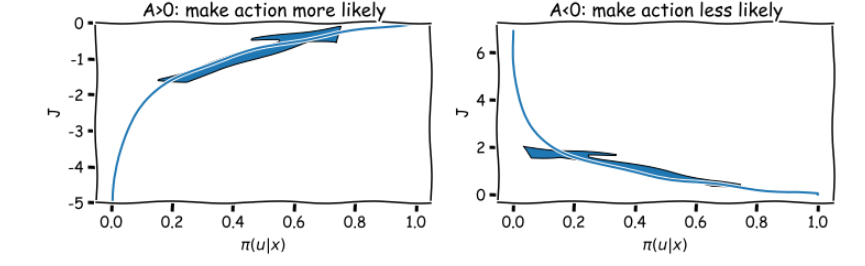

The update rule for the policy function is gradient **ascent** (since we maximize):

$$\theta \leftarrow \theta + \alpha_a \nabla_\theta J(\theta, x_t)$$

where $\alpha_a$ is the step size for the policy gradient.

The value function is updated using a simple MSE **loss** of the following form: 

$$L_{VF}(\eta) = \frac{1}{T} \sum_t \frac{1}{2} (V_{\eta}(x_t) - G_t)^2$$


with $G_t$ often chosen as $G_t = r_t + \gamma V_\eta(x_{t+1})$. This results in the following gradient **decent** step update.

$$\eta \leftarrow \eta - \alpha_c \nabla_\eta L_{VF}$$

and $\alpha_c$ the step size for the value function. For instance, in tabular learning this results in the following update rule for a given $x_t$:

$$V(x_t) \leftarrow V(x_t) - \alpha_c (V(x_t) - (r_{t+1} + \gamma V(x_{t+1})) ) $$

### Exercise 0: Installations

**Run** the following cell to install all the modules needed for this exercise if you haven't already (`gymnasium` for control problems, `Box2D` for some extra control problems, and `tqdm` for progress bars). 
If this installation fails open anaconda prompt in admin mode and use the same command `pip install gymnasium Box2D tqdm`. Then, restart the notebook (You might need to use `conda activate ml4sc` first before installing)

In [1]:
!pip install Box2D tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      Using setuptools (version 69.0.3).
      error: command 'swig' failed: No such file or directory
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for Box2D
  Running setup.py clean for Box2D
Failed to build Box2D
ERROR: Could not build wheels for Box2D, which is required to install pyproject.toml-based projects


In [6]:
%pip install pygame -q

Note: you may need to restart the kernel to use updated packages.


### Exercise 1: Multi-Armed Bandit  Actor-Critic Solution

To understand how the actor-critic method works, implement the actor-critic algorithm for the multi-armed bandit problem.

**a)** Derive the update rule for the policy/actor $\pi_\theta(u)$ which maximizes the performance 

$$ J(\theta) = A_t \log(\pi_\theta(u))$$ 

Given that the actor is represented by the softmax function:
 
 $$\pi_\theta(u) = \frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)}$$
 
 where each $\theta_k$ is a policy parameter corresponding to a specific discrete action.
 
**Answer a):** 

We start by applying the update rule for policy parameters in the actor-critic method. The update rule is based on the gradient ascent method, aiming to maximize the performance $J(\theta)$.
$$ \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} J$$
We expand $J(\theta)$ and apply the chain rule to derive the gradient:
$$ \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} log(\pi(u)) A_t $$

Next, we differentiate the logarithm function:
$$    \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} (\theta_u - log(\sum_k \exp(\theta_k))) A_t $$

Note that
$$ \frac{\partial}{\partial \theta_i} \log(\pi_\theta(u)) = \frac{\partial}{\partial \theta_i} \log \left( \frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)} \right) = \frac{\partial}{\partial \theta_i} \left( \theta_u - \log \left( \sum_k \exp(\theta_k) \right) \right)$$
Then, we compute the partial derivative with respect to $\theta_i$:
$$     \theta_i \leftarrow \theta_i + \alpha (\delta_{iu} - \frac{\partial}{\partial \theta_i} log(\sum_k \exp(\theta_k))) A_t $$
Where $\delta_{iu}$ is the Kronecker delta defined as $\delta_{iu} = 1$ if $i=u$, otherwise $0$.
For the second term, we apply the derivative of the log-sum-exp function:
$$
\frac{\partial}{\partial \theta_i} \log \left( \sum_k \exp(\theta_k) \right) = \frac{\exp(\theta_i)}{\sum_k \exp(\theta_k)}
$$

Further simplifying:
$$     \theta_i \leftarrow \theta_i + \alpha (\delta_{iu} - \frac{\exp(\theta_i)}{\sum_k \exp(\theta_k)}) A_t $$
Finally, replacing $\pi(i)$ with $\frac{\exp(\theta_i)}{\sum_k \exp(\theta_k)}$:
$$     \theta_i \leftarrow \theta_i + \alpha (\delta_{iu} - \pi(i)) A_t $$  


**b)** Complete writing the softmax function $\frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)}$ below.
 
 *tip: use h-np.max(h) to ensure numerical stability* 
 
**c)** Start implemeting the Actor-Critic algorithm by choosing an action according to the probabilities given by the policy of the Actor as $$P(u)  = \pi_\theta(u) = \frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)}$$ where $\theta$ is given by `Actor` in the code. Apply this randomly chosen action on the enviroment. 
 
 *tip: use `np.random.choise` using the `p` option to select an action and `bandit.step` to apply the action*
 
**d)** Calculate and apply the gradients of both the actor (`Actor`) and critic (`Critic`).
 
*tip: $V(x_{t+1}) = 0$ as the multi-armed bandit does not have an internal state*
 
**e)** Set the step size of the critic to zero and observe the change in training speed and stability.

**Answer e):** 
The actor still converges to the correct action but it is much slower and less stable. 

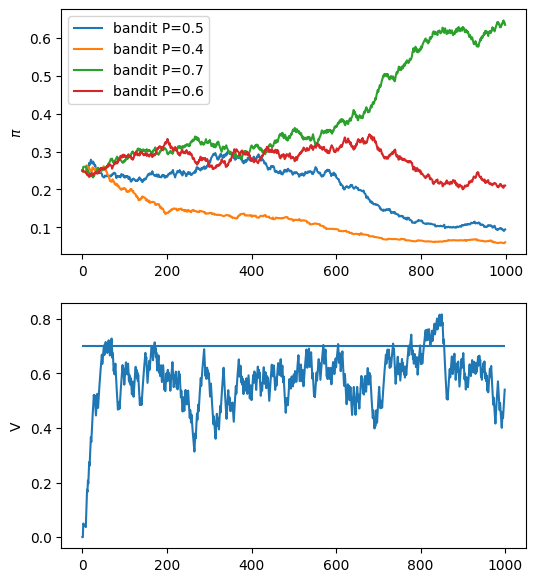

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt


class Multiarmed_bandit(gym.Env):
    def __init__(self, P = [lambda k: 0.5, lambda k: 0.4, lambda k: 0.7, lambda k: 0.6]):
        self.P = P
        self.action_space = spaces.Discrete(len(self.P)) #u = 0, 1, ..., len(P)-1
        self.k = 0
    
    def step(self, u):
        Pnow = self.P[u] #select the uth element
        obs = None
        reward = int(np.random.rand()<Pnow(self.k)) #set reward to 1 if random uniform < P
        terminated = True #there is no memory in the system
        info = {} 
        self.k += 1
        return obs, reward, terminated, False, info

def softmax(h):
    hp = h-np.max(h) #b) #some addtional numerical stability.
    return np.exp(hp)/np.sum(np.exp(hp)) #b)

bandit = Multiarmed_bandit()
Nact = bandit.action_space.n
Actor = np.zeros((Nact,)) #init actor, (Theta)
actions = np.arange(Nact,dtype=int)
Critic = 0 #init critic
step_size_actor = 0.05 #alpha_a
step_size_critic = 0.05 #alpha_c
prob_hist = []
critic_hist = []

for i in range(1000):
    #take action
    probs = softmax(Actor) #c)
    action = np.random.choice(actions,p=probs) #c=)
    obs, reward, terminated, truncated, info = bandit.step(action) #c)
    
    #calculate gradients for both the actor and the critic:
    advantage = (reward-Critic) #d)
    tmp = np.zeros((Nact,)) #d)
    tmp[action] = 1 #d)
    grad_actor = (tmp-probs)*advantage #d)
    grad_critic = Critic-reward #d)
    
    #apply gradients:
    Actor += step_size_actor*grad_actor #d) #sign = + due to performance and thus ascent
    Critic -= step_size_critic*grad_critic #d) #sign! #sign = - due to loss and thus descent
    
    #save results:
    prob_hist.append(softmax(Actor)) #save the probability of choosing a certain action
    critic_hist.append(Critic) #save the critic value

plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.plot(prob_hist)
plt.ylabel(r'$\pi$')
plt.legend([f'bandit P={Pi(0)}' for Pi in bandit.P])
plt.subplot(2,1,2)
plt.plot(critic_hist)
plt.hlines(0.7,0,len(critic_hist))
plt.ylabel(r'V')
plt.show()

## Exercise 2: Actor-Critic for Discrete Systems; A Tabular Solution

This exercise considers a discrete state/action system. The implementation is similar to the bandit of the previous exercise and we will be using the [ `FrozenLake` environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

**a)** For a discrete state (with $N_\text{states}$ states) and action enviroment (with $N_\text{actions}$ actions), what would be appropriate shapes of the parameters variable for the value function $V_\eta(x_t)$ and the policy function $\pi_\theta(u|x)$ (still given by a softmax) when implementing them in the code below?

**Answer a):** 
There are $N_\text{states}$ possible inputs to $V_\eta(x_t)$ hence it requires a vector with length $N_\text{states}$. For the policy function $\pi_\theta(u_t|x_t)$ there are $N_\text{states}$ by $N_\text{actions}$ possible inputs hence, we could take a matrix of size ($N_\text{states}$ by $N_\text{actions}$). 

**b)** Pick an action according to the probability distrubution of the policy network $\pi_\theta(u|x)$ and calculate the advantage $A_t = G_t - V_\eta(x_t)$ with the returns $G_t$ defined as $G_t = r_{t+1} + \gamma V_\eta(x_{t+1})$.

**c)** Calculate and apply the actor and critic gradients. 

*tip: you can copy from exercise 1*

*tip: update only the row of `Actor[obs_start]` and value of `Critic[obs_start]`*

  0%|          | 0/100000 [00:00<?, ?it/s]

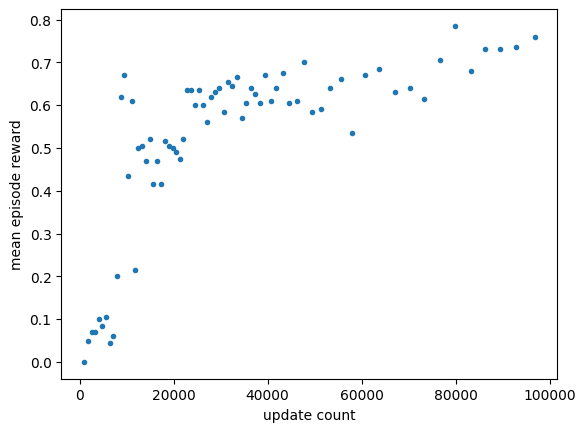

In [8]:
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
def eval_actor(Actor,env, deterministic=True):
    actions = np.arange(env.action_space.n,dtype=int)
    reward_acc = 0
    obs, info = env.reset()
    while True:
        action = np.argmax(Actor[obs]) if deterministic else np.random.choice(actions,p=softmax(Actor[obs_start]))
        obs, reward, terminated, truncated, info = env.step(action)
        reward_acc += reward
        if terminated or truncated:
            env.reset()
            return reward_acc
    
def softmax(h):
    hp = h-np.max(h)
    return np.exp(hp)/np.sum(np.exp(hp))

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
Actor = np.zeros((env.observation_space.n, env.action_space.n)) #a=) #array of size (N states, N actions)
Critic = np.zeros((env.observation_space.n,)) #a=) array of size (N states,)
actions = np.arange(env.action_space.n,dtype=int)

obs_start, info = env.reset()
step_size_actor = 0.1
step_size_critic = 0.3
gamma = 0.95
rewards = []
index = []
it = 0
for i in tqdm(range(100_000)):
    #take action
    probs = softmax(Actor[obs_start]) #b=)
    action = np.random.choice(actions,p=probs) #b=)
    
    obs_next, reward, terminated, truncated, info = env.step(action)
    
    if terminated:
        returns = reward #b)
    else:
        returns = reward+gamma*Critic[obs_next] #b)
    
    advantage = (returns-Critic[obs_start]) #b=)
    
    tmp = np.zeros((env.action_space.n,)) #c)
    tmp[action] = 1 #c)
    grad_actor = (tmp-probs)*advantage #c)  
    grad_critic = -advantage #c) 
    
    Actor[obs_start] += step_size_actor*grad_actor #c)
    Critic[obs_start] -= step_size_critic*grad_critic #c)
    
    if terminated or truncated:
        it += 1
        if it%100==0:
            rewards.append(np.mean([eval_actor(Actor,env) for i in range(200)]))
            index.append(i)
        obs_start, info = env.reset()
    else:
        obs_start = obs_next
    
plt.plot(index,rewards,'.')
plt.xlabel('update count')
plt.ylabel('mean episode reward')
plt.show()

**d)** There are two ways to use the policy function $\pi_\theta(u|x)$ during evaluation.

 1. Take the most likely action $u = arg\max_u \pi_\theta(u|x)$
 2. or sample from the probability distrubution $u \sim \pi_\theta(u|x)$

It's dependent on the problem which approach works best. Evaluate this for the considered problem and reason about the result.

*tip: use the `deterministic` keyword in the `eval_actor` function*

In [9]:
print(np.mean([eval_actor(Actor, env, deterministic=True) for i in range(1000)])) #d)
print(np.mean([eval_actor(Actor, env, deterministic=False) for i in range(1000)])) #d)

0.727
0.0


**e)** Visualize the policy.

In [10]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="human")

obs, info = env.reset()
env.render()
while True:
    action = np.argmax(Actor[obs]) #e=)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        env.close()
        break
    

## Exercise 3: The Continuous Multi-Armed Bandit

Let us consider that we do not have a finite number of multi-armed bandit but a continuous line. 

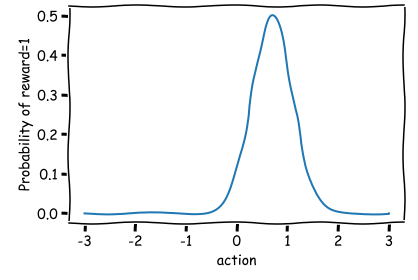

We want to train an agent such that it finds the action at $0.7$ which returns the highest expected reward.


For this problem, we can use Actor-Critic since it is capable to handle continuous action spaces (Actor-Critic is most often used for its stability and ease of use). For instance, one can write the policy function as the probability density function of a fixed variance normal function:

$$ \pi_\theta (u|x) = \frac{1}{\sigma_u \sqrt{2 \pi}} \exp\left(-\frac{(\bar u_\theta(x)-u)^2}{2 \sigma_u^2} \right)$$

**a)** Derive the policy update rule for this form of the policy function using 

$$\theta \leftarrow \theta + \alpha_a \nabla_\theta J(\theta)$$

assuming that in the case of the multi-armed bandit that

$$\bar u_\theta(x) = \theta$$

with the performance function defined as

$$ J(\theta) = A_t \log(\pi_\theta(u))$$

**Answer a):**
1. The log probability of selecting an action $u$ can be approximated as:
$$ \log(\pi_\theta(u)) \sim -\frac{(\bar u_\theta(x)-u)^2}{2 \sigma_u^2} $$
(Constants are ignored since they do not affect the gradient).

2. Update the policy parameters $\theta$
 $$ \theta \leftarrow \theta + \alpha_a A_t \nabla_\theta -\frac{(\theta-u)^2}{2 \sigma_u^2} $$
3. Compute the gradient:
  $$ \theta \leftarrow \theta + \alpha_a A_t \left (-\frac{\theta-u}{\sigma_u^2} \right) $$

**b)** Implement the Actor-Critic approach for the continuous multi-armed bandit problem. 

*tip 1: use `np.random.normal` to sample for an action*

*tip 2: The Critic update and advantage is the same as exercise 1*

**c)** Re-run with different initial values of `Actor`=$\theta$ and formulate how they influence the resulting performance.

**Answer c):** If $\theta$ is too far from 0.7 then the agent will never see any rewards and hence change.

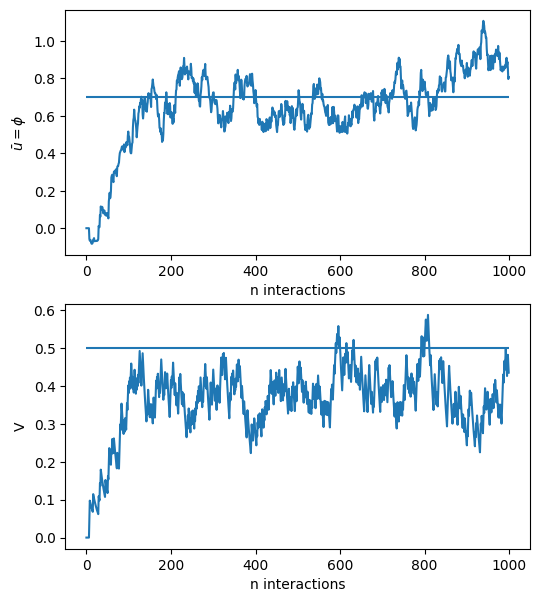

In [11]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt

class Multiarmed_bandit_continues(gym.Env):
    def __init__(self, P = lambda action: np.exp(-1/2*(0.7-action)**2/0.4**2)*0.5):
        self.P = P
        l = np.array([-float('inf')]).astype(np.float32)
        self.action_space = spaces.Box(low=l,high=-l) #u = 0, 1, ..., len(P)-1

    
    def step(self, u):
        obs = None
        reward = int(np.random.rand()<self.P(u)) #set reward to 1 if random uniform < P
        terminated = True #there is no memory in the system
        info = {} 
        return obs, reward, terminated, False, info

bandit = Multiarmed_bandit_continues()
Actor = 0 #u mean
sigma_u = 0.3 #fixed std
Critic = 0
step_size_actor = 0.02
step_size_critic = 0.05
prob_hist = []
critic_hist = []

for i in range(1000):
    #take action
    action = np.random.normal(loc=Actor,scale=sigma_u) #b=)
    obs, reward, terminated, truncated, info = bandit.step(action)
    
    advantage = reward-Critic #b)
    
    grad_actor = -(Actor-action)/(sigma_u**2)*advantage #b)
    grad_critic = Critic-reward #b)
    
    Actor += step_size_actor*grad_actor #b=) ascent
    Critic -= step_size_critic*grad_critic #b=) decent

    prob_hist.append(Actor)
    critic_hist.append(Critic)

    
from matplotlib import pyplot as plt

plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.ylabel(r'$\bar u = \phi$')
plt.xlabel('n interactions')
plt.hlines(0.7,0,len(critic_hist))
plt.plot(prob_hist)
plt.subplot(2,1,2)
plt.plot(critic_hist)
plt.ylabel(r'V')
plt.xlabel('n interactions')
plt.hlines(bandit.P(0.7),0,len(critic_hist))
plt.show()

**d)** Up until now we enforced a fixed $\sigma_u$. However, $\sigma_u$ can also be introduced as a parameter that is updated during the policy update step. Implement this new update rule as follows:
*tip: Write $\sigma_u = \exp(\theta_2)$ and $\bar u = \theta_1$ to ensure that $\sigma_u>0$.*
*tip: re-derive the policy update rule taking care of the normalization term of the normal distribution.*

**Answer d):** 
1. Policy Function with $\sigma_u$ as a parameter:
$$ \pi_\theta (u) = \frac{1}{\exp(\theta_2) \sqrt{2 \pi}} \exp\left(-\frac{(\theta_1-u)^2}{2 \exp(\theta_2)^2} \right) $$
Here, $\theta_1$ represents the mean, and $\exp (\theta_2)$ represents the standard deviation $\sigma_u$.

2. Gradient with Respect to $\theta_1$
 $$ \frac{\partial}{\partial \theta_1} \log \pi_\theta(u) = -\frac{\theta_1-u}{\exp(\theta_2)^2} $$
3. Gradient with Respect to $\theta_2$
  $$ \frac{\partial}{\partial \theta_2} \log \pi_\theta(u) = \frac{(\theta_1-u)^2}{\exp(\theta_2)^2} - 1$$
These gradients are used to update the policy parameters  $\theta_1$, and $\theta_2$ accordingly.

**e)** As you might notice this optimization is unstable, this can be attributed to policy collapce seen be $\sigma_u$ going to zero. This collapce can be prevented by introducing an additional term in the optimization which aim to give "reward" for higher $\sigma_u$. This reward is commonly encoded using an (differential) entropy term ($S(\theta)$) creating a new loss function as $$ L_{\text{actor}}(\theta) = \text{actor policy loss} - \alpha_S S(\theta)$$ where the entropy term is given by 
$$
\alpha_S S(\theta) = \alpha_S \log \left ( \sigma_u \sqrt{2 \pi e} \right )
$$ 
where $\alpha_S$ is a weighting. Hence now, derive the update rule including the entropy term. Afterward implement this update rule and observe the changes depedent on $\alpha_S$.

**Answer e):** 
If we use the results of section d, we can write the entropy as:
$$
 S(\theta) =  \log \left ( \sigma_u \sqrt{2 \pi e} \right ) = \theta_2 + \log \left (\sqrt{2 \pi e} \right ) 
$$ 
since  $\exp (\theta_2)$ represents the standard deviation $\sigma_u$.

Hence, the modified loss function will be
$$ 
L_{\text{actor}}(\theta) = \text{actor policy loss} - \alpha_S (\theta_2 + \log \left (\sqrt{2 \pi e} \right ) )
$$
now we can compute the gradients of the modified loss function. For $\theta_1$, we have:
$$
\frac{\partial}{\partial \theta_1} L_{\text{actor}}(\theta) = \frac{\partial}{\partial \theta_1} \text{actor policy loss}
$$
If we denote the advantage estimate as $A$ then:
$$\frac{\partial}{\partial \theta_1} L_{\text{actor}}(\theta) = -A \frac{\theta_1-u}{\exp(\theta_2)^2} $$

For $\theta_2$, we can write:
$$
\frac{\partial}{\partial \theta_2} L_{\text{actor}}(\theta) = \frac{\partial}{\partial \theta_2} \text{actor policy loss} - \alpha_S \frac{\partial}{\partial \theta_2} (\theta_2 + \log(\sqrt{2 \pi e}))
$$

$$ 
\frac{\partial}{\partial \theta_2} L_{\text{actor}}(\theta) = \left( \frac{(\theta_1 - u)^2}{\exp(\theta_2)^2} - 1 \right)A - \alpha_S
$$



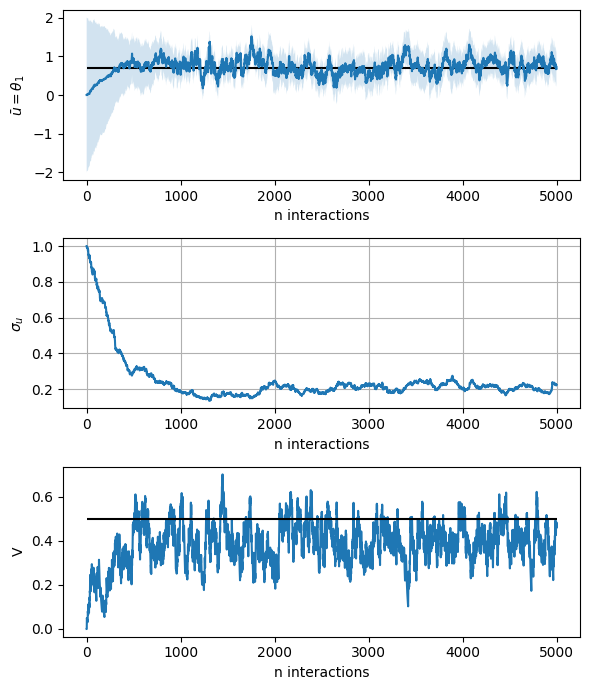

In [12]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt

class Multiarmed_bandit_continues(gym.Env):
    def __init__(self, P = lambda action: np.exp(-1/2*(0.7-action)**2/0.4**2)*0.5):
        self.P = P
        l = np.array([-float('inf')]).astype(np.float32)
        self.action_space = spaces.Box(low=l,high=-l) #u = 0, 1, ..., len(P)-1

    
    def step(self, u):
        obs = None
        reward = int(np.random.rand()<self.P(u)) #set reward to 1 if random uniform < P
        terminated = True #there is no memory in the system
        info = {} 
        return obs, reward, terminated, False, info

np.random.seed(32)
bandit = Multiarmed_bandit_continues()
theta1 = 0 
theta2 = 0
Critic = 0
step_size_actor = 0.02
step_size_critic = 0.05
mean_u_hist = []
sigma_u_hist = []
critic_hist = []
alpha_entropy = 0.05
entropy_included = True #switch this to true when you have implemented e)

for i in range(5000):
    #take action
    sigma_u = np.exp(theta2) #d=)
    action = np.random.normal(loc=theta1,scale=sigma_u)
    obs, reward, terminated, truncated, info = bandit.step(action)
    
    advantage = reward-Critic
    
    grad_actor_theta1 = -(theta1-action)/(sigma_u**2)*advantage #d=)
    grad_actor_theta2 = ((theta1-action)**2/(sigma_u**2) - 1)*advantage #d=)
    if entropy_included:
        pass #add something to grad_actor_theta2...
        grad_actor_theta2 += -alpha_entropy*theta2 #e)
    grad_critic = Critic-reward
    
    theta1 += step_size_actor*grad_actor_theta1 
    theta2 += step_size_actor*grad_actor_theta2 
    Critic -= step_size_critic*grad_critic 

    mean_u_hist.append(theta1)
    sigma_u_hist.append(np.exp(theta2))
    critic_hist.append(Critic)
mean_u_hist = np.array(mean_u_hist)
sigma_u_hist = np.array(sigma_u_hist)
    
from matplotlib import pyplot as plt

plt.figure(figsize=(6,7))
plt.subplot(3,1,1)
plt.ylabel(r'$\bar u = \theta_1$')
plt.xlabel('n interactions')
plt.hlines(0.7,0,len(critic_hist),colors='k')
plt.plot(mean_u_hist)
plt.fill_between(np.arange(len(mean_u_hist)), mean_u_hist-2*sigma_u_hist, mean_u_hist+2*sigma_u_hist,alpha=0.2)

plt.subplot(3,1,2)
plt.plot(sigma_u_hist)
plt.ylabel(r'$\sigma_u$'); plt.xlabel('n interactions'); plt.grid()

plt.subplot(3,1,3)
plt.plot(critic_hist)
plt.ylabel(r'V')
plt.xlabel('n interactions')
plt.hlines(bandit.P(0.7),0,len(critic_hist),colors='k')
plt.tight_layout()
plt.show()


## Exercise 4: Actor-Critic Neural Networks

In this exercise, you combine your knowledge of neural networks and the actor-critic method. We will consider the [cart pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) gymnasium environment which has a discrete action space. This implementation employs many of the methods you saw in the previous exercise set where we implemented deep Q learning. This exercise implements the A2C algorithm (a synchronous, deterministic variant of Asynchronous Advantage Actor-Critic (A3C)).

**a)** Implement a neural network that implements an actor as
$$
\pi_\theta(.|x) = \text{softmax}(\text{ANN}(x))
$$
where the ANN has the same number of outputs actions, and a critic $$V_\eta(x)$$ which is a neural network with 1 `output`. Let both functions be parameterized as 1 `hidden layer` Neural Networks with `tanh` activations.

*tip: for numerical stability, we return `logp` if needed.*

In [13]:
import torch.nn as nn
import torch
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt

class ActorCritic(nn.Module):
    def __init__(self, env, hidden_size=40):
        super(ActorCritic, self).__init__()
        num_inputs = env.observation_space.shape[0]
        num_actions = env.action_space.n

        #define your layers here:
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)  #a)
        self.critic_linear2 = nn.Linear(hidden_size, 1) #a)
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size) #a)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions) #a)
    
    def actor(self, state, return_logp=False):
        #state has shape (Nbatch, Nobs)
        hidden = torch.tanh(self.actor_linear1(state)) #a)
        h = self.actor_linear2(hidden) #a=)
        h = h - torch.max(h,dim=1,keepdim=True)[0] #for additional numerical stability
        logp = h - torch.log(torch.sum(torch.exp(h),dim=1,keepdim=True)) #log of the softmax
        if return_logp:
            return logp
        else:
            return torch.exp(logp) #by default it will return the probability
    
    def critic(self, state):
        #state has shape (Nbatch, Nobs)
        hidden = torch.tanh(self.critic_linear1(state)) #a)
        return self.critic_linear2(hidden)[:,0] #a) #no activation function
    
    def forward(self, state):
        #state has shape (Nbatch, Nobs)
        return self.critic(state), self.actor(state)

env = gym.make('CartPole-v1')
env = gym.make('Acrobot-v1')
actor_crit = ActorCritic(env, hidden_size=40)

obs, info = env.reset()
probs = actor_crit.actor(torch.as_tensor(obs,dtype=torch.float32)[None,:])[0] #call the actor
value = actor_crit.critic(torch.as_tensor(obs,dtype=torch.float32)[None,:])[0] #call the critic
print(f'value={value}')
print(f'probs={probs}') #sums to 1
pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].detach().numpy() #shorthand
pi(obs)

value=-0.19195152819156647
probs=tensor([0.1957, 0.4289, 0.3754], grad_fn=<SelectBackward0>)


array([0.19571796, 0.42886198, 0.37542006], dtype=float32)

**b)** Next, finish the implementation of the `rollout`, `eval_actor` and `show` function. In the rollout sample, the action distribution given by the actor. Whereas, for `eval_actor` and `show` functions the action is chosen which is most likely.

Start_state=[[ 9.99214411e-01  3.96299586e-02  9.99999762e-01  7.09522690e-04
   2.84737628e-03 -4.14612852e-02]
 [ 9.99756455e-01  2.20695175e-02  9.99532282e-01  3.05803511e-02
  -1.73785269e-01  3.31863910e-01]
 [ 9.99916375e-01 -1.29342014e-02  9.95735526e-01  9.22535881e-02
  -1.67301163e-01  2.70174593e-01]
 [ 9.99142945e-01 -4.13932279e-02  9.91199315e-01  1.32377788e-01
  -1.10518411e-01  1.22604460e-01]
 [ 9.99127269e-01 -4.17699032e-02  9.94582415e-01  1.03950836e-01
   1.05752565e-01 -4.03648376e-01]
 [ 9.99998450e-01 -1.74502633e-03  9.99758601e-01 -2.19721310e-02
   2.82286674e-01 -8.29065025e-01]
 [ 9.98698652e-01  5.09999134e-02  9.84218180e-01 -1.76959381e-01
   2.29820654e-01 -6.95215344e-01]
 [ 9.95229065e-01  9.75656509e-02  9.48779583e-01 -3.15938830e-01
   2.23227188e-01 -7.08632946e-01]
 [ 9.92543399e-01  1.21891543e-01  9.14774597e-01 -4.03964639e-01
   1.52106071e-02 -2.18788013e-01]
 [ 9.93279576e-01  1.15739547e-01  9.04999435e-01 -4.25412804e-01
  -7.62675256

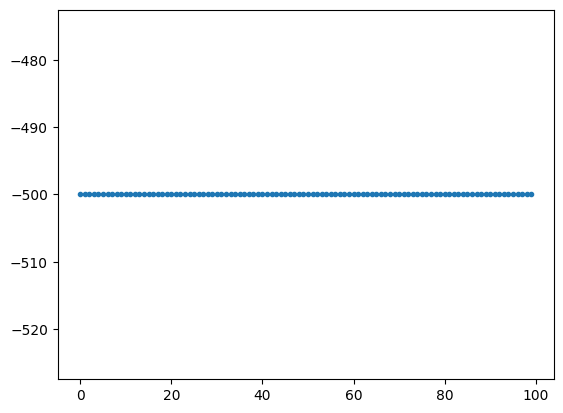

In [14]:
import time

def rollout(actor_crit, env, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        obs, info = env.reset() 
        for i in range(N_rollout): 
            action = np.random.choice(env.action_space.n,p=pi(obs)) #b=)

            Start_state.append(obs) 
            Actions.append(action)

            obs_next, reward, terminated, truncated, info = env.step(action)

            Terminal.append(terminated)
            Rewards.append(reward) 
            End_state.append(obs_next) 

            if terminated or truncated: 
                obs, info = env.reset() 
            else:
                obs = obs_next
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Terminal)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

def eval_actor(actor_crit, env):
    
    with torch.no_grad():
        rewards_acc = 0 
        obs, info = env.reset() 
        while True: 
            action = np.argmax(pi(obs)) #b=)
            obs, reward, terminated, truncated, info = env.step(action)
            rewards_acc += reward 
            if terminated or truncated: 
                return rewards_acc 

def show(actor_crit,env):
    pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        try:
            obs, info = env.reset() 
            env.render() 
            time.sleep(1) 
            while True: 
                action = np.argmax(pi(obs)) #b=)
                obs, reward, terminated, truncated, info = env.step(action) 
                # time.sleep(1/60) 
                env.render()
                if terminated or truncated: 
                    time.sleep(0.5) 
                    break  
        finally: #this will always run even when an error occurs
            env.close()


# env = gym.make('CartPole-v1')
env_name = 'Acrobot-v1'
gym.envs.classic_control.AcrobotEnv.metadata['render_fps'] = 30
env = gym.make(env_name)
env_vis = gym.make(env_name, render_mode='human')
actor_crit = ActorCritic(env, hidden_size=40)

Start_state, Actions, Rewards, End_state, Terminal = rollout(actor_crit,env,N_rollout=20)
print(f'Start_state={Start_state}')
print(f'Actions={Actions}')
print(f'Rewards={Rewards}')
print(f'End_state={End_state}')
print(f'Terminal={Terminal}')
plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
show(actor_crit,env_vis)

**c)** Finish implementing the A2C algorithm seen below. Remember that 

$$
A_t = TD = r_{t+1} + \gamma V_\eta(x_{t+1}) - V_\eta(x_{t}) $$
$$
L_{VF} = A_t^2$$
$$
L_{pg} = - A_t \log(\pi_\theta(u_t|x)t)
$$
where $A_t$ is excluded from the policy gradient.
$$
L_{entropy} = -S = - \sum_u - \pi_\theta(u|x_t) \log(\pi_\theta(u|x_t))$$
$$
L = L_{VF} + \alpha_a L_{pg} + \alpha_{\text{entropy}} L_{entropy}
$$

*tip: use `return_logp` for increased numerical stability*

*tip: use `.detach()` on $A_T$ calculating $L_{pg}$ to exclude it from the gradient calculation.*

*tip: do not forget the terminal state*

In [15]:
def A2C_rollout(actor_crit, optimizer, env, alpha_actor=0.5, alpha_entropy=0.5, gamma=0.98, \
                N_iterations=21, N_rollout=20000, N_epochs=10, batch_size=32, N_evals=10):
    best = -float('inf')
    torch.save(actor_crit.state_dict(),'actor-crit-checkpoint')
    try:
        for iteration in range(N_iterations):
            print(f'rollout iteration {iteration}')
            
            #2. rollout 
            Start_state, Actions, Rewards, End_state, Terminal = rollout(actor_crit, env, N_rollout=N_rollout)
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Terminal = convert([Start_state, Rewards, End_state, Terminal])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Terminal_batch = \
                    [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Terminal]]
                    
                    #Advantage:
                    Vnow = actor_crit.critic(Start_state_batch) #c=)
                    Vnext = actor_crit.critic(End_state_batch) #c=)
                    A = Rewards_batch + gamma*Vnext*(1-Terminal_batch) - Vnow #c=)
                    
                    # action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0) #to filter actions
                    logp = actor_crit.actor(Start_state_batch,return_logp=True) #c=)
                    logp_cur = logp[np.arange(batch_size), Actions_batch] #c=)
                    p = torch.exp(logp) #c=) #probability for with all actions in a list
                    p_cur = torch.exp(logp_cur) #c=) #probability for choosing the current chosen action
                    
                    L_value_function = torch.mean(A**2) #c=)
                    L_policy = -(A.detach()*logp_cur).mean() #c=) #detach A, the gradient should only to through logp
                    L_entropy = -torch.mean((-p*logp),0).sum() #c=) 
                    
                    Loss = L_value_function + alpha_actor*L_policy + alpha_entropy*L_entropy #c=) 
                    
                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
                
                print(f'logp{p[0]} logp{logp.shape}')

                score = np.mean([eval_actor(actor_crit, env) for i in range(N_evals)])
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                print('\t Value loss:  ',L_value_function.item())
                print('\t Policy loss: ',L_policy.item())
                print('\t Entropy:     ',-L_entropy.item())
                
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving actor-crit... \n#################################')
                    torch.save(actor_crit.state_dict(),'actor-crit-checkpoint')
            
            print('loading best result')
            actor_crit.load_state_dict(torch.load('actor-crit-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        actor_crit.load_state_dict(torch.load('actor-crit-checkpoint'))

**d)** Use the `A2C` function to train an agent on the Cart pole enviroment. Tune and understand the hyperparameters. 

In [16]:
import torch
from torch import nn
import gymnasium as gym

# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
env_name = 'CartPole-v1'
gym.envs.classic_control.CartPoleEnv.metadata['render_fps'] = 30
env = gym.make(env_name)
env_vis = gym.make(env_name, render_mode='human')


gamma = 0.98 
batch_size = 32 
N_iterations = 5 
N_rollout = 20000 
N_epochs = 5 
N_evals = 10 
alpha_actor = 0.5
alpha_entropy = 0.5 #changing this will change how much entropy is weighted (decrease if Entropy=0)
# alpha_entropy = 0.74 for Acrobot-v1
lr = 0.005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
actor_crit = ActorCritic(env, hidden_size=40)
optimizer = torch.optim.Adam(actor_crit.parameters(), lr=lr) #low learning rate
# This implementation is not reccomanded for the design assignment. 
# There might errors in this implementation and i'm not sure where.
A2C_rollout(actor_crit, optimizer, env, alpha_actor=alpha_actor, alpha_entropy=alpha_entropy,\
                         gamma=gamma, N_iterations=N_iterations, N_rollout=N_rollout, N_epochs=N_epochs, \
                         N_evals=N_evals)

rollout iteration 0
starting training on rollout information...
logptensor([0.4474, 0.5526], grad_fn=<SelectBackward0>) logptorch.Size([32, 2])
iteration=0 epoch=0 Average Reward per episode: 227.7
	 Value loss:   0.6994926929473877
	 Policy loss:  0.4938749670982361
	 Entropy:      0.6818049550056458
################################# 
 new best 227.7 saving actor-crit... 
#################################
logptensor([0.4274, 0.5726], grad_fn=<SelectBackward0>) logptorch.Size([32, 2])
iteration=0 epoch=1 Average Reward per episode: 214.3
	 Value loss:   0.48757678270339966
	 Policy loss:  0.3455774784088135
	 Entropy:      0.6806806325912476
logptensor([0.4263, 0.5737], grad_fn=<SelectBackward0>) logptorch.Size([32, 2])
iteration=0 epoch=2 Average Reward per episode: 198.2
	 Value loss:   0.408297598361969
	 Policy loss:  0.3112850487232208
	 Entropy:      0.681034505367279
logptensor([0.4286, 0.5714], grad_fn=<SelectBackward0>) logptorch.Size([32, 2])
iteration=0 epoch=3 Average Rewar

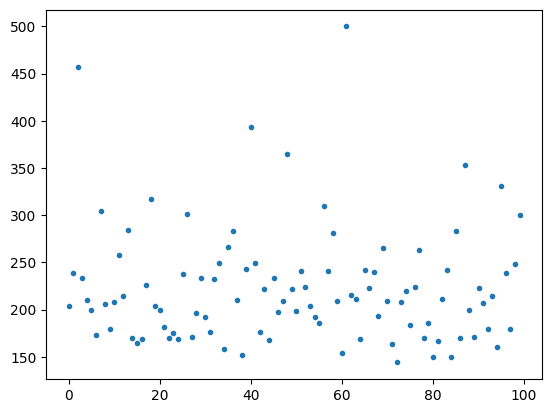

In [17]:
plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
show(actor_crit,env_vis)

## Exercise 5: ANN Actor-Critic with Stable-Baselines

In practical applications of RL, one would not implement the RL algorithm themself but use an open-source library. For model-free neural network-based approaches I recommend using [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/rl.html). 

**Run** the next cell to install it. see: [install guide](https://stable-baselines3.readthedocs.io/en/master/guide/install.html) for more information.

In [18]:
!pip install stable-baselines3[extra]
# !pip install protobuf==3.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.0 MB/s eta 0:00:0000:01
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446664 sha256=fd5ea07d1deb0dd6df803b477235c48c7fc4bf4537dcf78e52a227cdb6866879
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.

**a)** Run the cart pole example using the A2C algorithm. (A synchronous, deterministic variant of Asynchronous Advantage Actor-Critic (A3C).)
https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html

**b)** Re-run this block with the PPO algorithm. (https://arxiv.org/pdf/1707.06347.pdf)

**c)** Re-run with `Pendulum` and `Lunar Lander` and observe results.

In [19]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, SAC


env_id = "CartPole-v1"
env = gym.make(env_id)

model = A2C('MlpPolicy', env, verbose=1)
model = PPO('MlpPolicy', env, verbose=1) #b)
model.learn(total_timesteps=25000)


import time
env = gym.make(env_id, render_mode='human')
obs, info = env.reset()
try:
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        # time.sleep(1/50)
        if terminated or truncated:
            env.reset()
finally:
    env.close()


2024-07-27 11:50:58.423731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 11:50:58.423898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 11:50:58.581479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.7     |
|    ep_rew_mean     | 23.7     |
| time/              |          |
|    fps             | 1437     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 27.1       |
|    ep_rew_mean          | 27.1       |
| time/                   |            |
|    fps                  | 1034       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00847408 |
|    clip_fraction   